### The command for install package

pip install numpy

pip install opencv-python

pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

pip install matplotlib

In [8]:
import numpy as np
import cv2 as cv
from PIL import Image, ImageEnhance
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, transforms,models
import matplotlib .pyplot as plt
from itertools import permutations, combinations
import os
import random
import scipy.stats as stats

### MRs

In [3]:
def scale(x, scalar):
    height = int(x.size[0] * scalar)
    width = int(x.size[1] * scalar)
    dim = (width, height)
    return x.resize(dim)

def rotate(x, degree):
    # Rotate the image by degrees counter clockwise
    return x.rotate(degree)

def enh_bri(x, brightness):
    bri = ImageEnhance.Brightness(x)
    return bri.enhance(brightness)

def enh_con(x, contrast):
    con = ImageEnhance.Contrast(x)
    return con.enhance(contrast)

def enh_sha(x, sharpness):
    sha = ImageEnhance.Sharpness(x)
    return sha.enhance(sharpness)

def gaussian(x, kernel_size):
    x = np.array(x)
    x = cv.GaussianBlur(x, kernel_size, sigmaX=0)
    return Image.fromarray(x)

def shear(x, shear_factor):
    # 定义错切变换矩阵
    shear_matrix = [1, shear_factor, 0, 0, 1, 0]

    # 创建Affine对象并应用错切变换
    sheared_img = x.transform(
        x.size, Image.Transform.AFFINE, shear_matrix
    )
    return sheared_img

def translate(x, shift):
    shift_x, shift_y = shift[0], shift[1]
    # 进行平移操作
    translated_img = x.transform(
        x.size, Image.Transform.AFFINE, (1, 0, shift_x, 0, 1, shift_y)
    )
    return translated_img

mrs = [rotate, enh_bri, enh_sha, enh_con, gaussian, shear, translate]
mrs_name =[mr.__name__ for mr in mrs]
print(mrs_name)
paras = [3, 0.8, 0.8, 0.8, (3, 3), 0.1, (1,1)]



['rotate', 'enh_bri', 'enh_sha', 'enh_con', 'gaussian', 'shear', 'translate']


### 不能重复使用MR,叠加会出问题

In [4]:
# 数据预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图像大小以适应预训练模型的输入大小
    transforms.Grayscale(num_output_channels=3),  # 将灰度图像转换为三通道输入
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# 加载 MNIST 数据集
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 创建数据加载器
batch_size = 256
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Train and save model

In [4]:
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 10)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    training_loss = 0
    for X,y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs,y)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {training_loss/len(train_loader):.4f}")

Epoch 1/5 - Loss: 0.1270
Epoch 2/5 - Loss: 0.0356
Epoch 3/5 - Loss: 0.0269
Epoch 4/5 - Loss: 0.0201
Epoch 5/5 - Loss: 0.0189


### Test model on source images

In [5]:
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 10)

model_name = 'MNIST_ResNet18_9906'
model.load_state_dict(torch.load('./models/'+model_name+'.pth'))


<All keys matched successfully>

In [20]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 调整图像大小以适应预训练模型的输入大小
    transforms.Grayscale(num_output_channels=3),  # 将灰度图像转换为三通道输入
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

batch_size = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size, shuffle=False)

model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 10)
model_name = 'MNIST_ResNet18_9906'
model.load_state_dict(torch.load('./models/'+model_name+'.pth'))
model.eval()
model.to(device)

correct = 0
total = 0
pred_source = np.zeros(len(mnist_testset),dtype=int)
#pred_source = np.load('predictions/MNIST_ResNet18_9906_source.npy')
with torch.no_grad():
    for i,(X,y) in enumerate(test_loader):
        X,y = X.to(device),y.to(device)
        outputs = model(X)
        _, pred = torch.max(outputs, 1)
        pred_source[i*batch_size:i*batch_size+X.size(0)] = pred.cpu()
        correct += (pred==y).sum().item()
        total += y.size(0)

accuracy = correct/total
print(accuracy)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.53 GiB (GPU 0; 23.69 GiB total capacity; 675.17 MiB already allocated; 1.20 GiB free; 696.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [10]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True)

class MNISTFOLLOWUP(Dataset):
    def __init__(self, mnist_dataset, cmr, transform=None):
        self.transform = transform
        self.data = []
        self.labels = []
        for idx, (img, label) in enumerate(mnist_dataset):
            for index in cmr:
                img = mrs[index](img, paras[index])
            self.data.append(img)
            self.labels.append(label)
            
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.transform is not None:
            self.data[idx] = self.transform(self.data[idx])
        return self.data[idx], self.labels[idx]
    

pred_followup = {}
for k in range(len(mrs)): 
    k = k+1
    for p in permutations(range(len(mrs)), k):
        if p in pred_followup.keys():
            continue
        print(p)
        temp = np.zeros(len(mnist_testset), dtype=int)
        dateset_followup = MNISTFOLLOWUP(mnist_dataset=mnist_testset, cmr=p, transform=transform)
        testload_followup = torch.utils.data.DataLoader(dateset_followup, batch_size=batch_size, shuffle=False)
        with torch.no_grad():
            for i,(X,y) in enumerate(testload_followup):
                X = X.to(device)
                outputs = model(X)
                _, pred = torch.max(outputs, 1)
                temp[i*batch_size:i*batch_size+X.size(0)] = pred.cpu()
        pred_followup[p] = temp

(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(1, 0)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(2, 0)
(2, 1)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(3, 0)
(3, 1)
(3, 2)
(3, 4)
(3, 5)
(3, 6)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 5)
(4, 6)
(5, 0)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(5, 6)
(6, 0)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 2, 1)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 3, 1)
(0, 3, 2)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 4, 1)
(0, 4, 2)
(0, 4, 3)
(0, 4, 5)
(0, 4, 6)
(0, 5, 1)
(0, 5, 2)
(0, 5, 3)
(0, 5, 4)
(0, 5, 6)
(0, 6, 1)
(0, 6, 2)
(0, 6, 3)
(0, 6, 4)
(0, 6, 5)
(1, 0, 2)
(1, 0, 3)
(1, 0, 4)
(1, 0, 5)
(1, 0, 6)
(1, 2, 0)
(1, 2, 3)
(1, 2, 4)
(1, 2, 5)
(1, 2, 6)
(1, 3, 0)
(1, 3, 2)
(1, 3, 4)
(1, 3, 5)
(1, 3, 6)
(1, 4, 0)
(1, 4, 2)
(1, 4, 3)
(1, 4, 5)
(1, 4, 6)
(1, 5, 0)
(1, 5, 2)
(1, 5, 3)
(1, 5, 4)
(1, 5, 6)
(1, 6, 0)
(1, 6, 2)
(1, 6, 3)
(1, 6, 4)
(1, 6, 5)
(2, 0, 1)
(2, 0, 3)
(2, 0, 4)
(2, 0, 5)
(2, 0, 6)
(2, 1, 0)
(2, 1, 3)
(

In [11]:
np.save('predictions/'+model_name.split('.')[0]+'_followup.npy', pred_followup)

[[33, 373, 27, 6309, 1222, 110, 112], [431, 50, 6418, 1319, 134, 136, 431, 581, 6372, 5493, 686, 604, 52, 574, 6738, 2118, 148, 126, 6348, 5988, 6766, 8907, 6613, 6414, 1436, 5417, 2043, 8911, 1941, 1700, 129, 686, 143, 6676, 1901, 253, 127, 604, 126, 6506, 1701, 232], [642, 6501, 5507, 758, 726, 628, 6894, 2214, 172, 178, 6120, 6913, 8919, 6741, 6558, 5453, 2147, 8923, 2059, 1909, 758, 172, 6801, 2005, 304, 726, 178, 6651, 1910, 317, 642, 6501, 5507, 758, 726, 643, 7098, 6298, 1022, 871, 6457, 7101, 8920, 6927, 6618, 5560, 6259, 8921, 6209, 5809, 750, 1021, 6926, 6174, 1059, 659, 870, 6663, 5810, 973, 635, 6899, 2232, 170, 178, 635, 7059, 6273, 1005, 859, 6833, 6757, 8963, 7129, 6867, 2409, 6206, 8965, 3100, 2728, 169, 1005, 7150, 3054, 304, 145, 859, 6949, 2726, 271, 6068, 6833, 8909, 6693, 6513, 6068, 6758, 8873, 6549, 6244, 6853, 6771, 8962, 7148, 6892, 8914, 8878, 8960, 8969, 8915, 6657, 6549, 7122, 8964, 6778, 6481, 6244, 6842, 8909, 6721, 5493, 2322, 8924, 2224, 2021, 5493, 6210

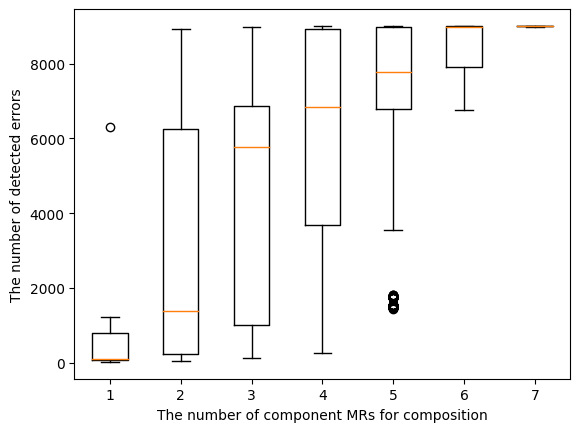

[6309, 8911, 8975, 8996, 9003, 9003, 9004]


In [7]:
model_name = 'MNIST_ResNet18_9906'

data = [[] for _ in range(len(mrs))]
pred_source = np.load('predictions/'+model_name.split('.')[0]+'_source.npy')
pred_followup = np.load('predictions/'+model_name.split('.')[0]+'_followup.npy',allow_pickle=True).item()

def error_detection(mr):
    return np.where(pred_followup[mr]!=pred_source)[0]

for mr in pred_followup.keys():
    data[len(mr)-1].append(len(error_detection(mr)))
print(data)

# 创建箱线图
plt.boxplot(data, patch_artist=False)

# 设置图表标题和轴标签
#plt.title('Boxplot Example')
plt.xlabel('The number of component MRs for composition')
plt.ylabel('The number of detected errors')

# 显示图表
plt.show()

print([max(error) for error in data])

In [13]:
errors = [set() for _ in range(len(mrs))]
for mr in pred_followup.keys():
    errors[len(mr)-1].update(error_detection(mr))
print([len(e) for e in errors])
with open('predictions/MNIST_ResNet18_9906_error_index.txt', 'w') as f:
    for error in errors:
        error = sorted(list(error))
        f.write(' '.join(map(str, error)) + '\n')

[6661, 8937, 9025, 9036, 9031, 9023, 9012]


In [21]:
errors_all = set()

errors = [set() for _ in range(len(mrs))]
for mr in pred_followup.keys():
    errors[len(mr)-1].update(error_detection(mr))

for error in errors:    
    errors_all.update(error)

t = set()
for i in range(len(errors)):
    t.update(errors[i])
    print(i, len(t)/len(errors_all))

0 0.9643
1 0.9933
2 0.9988
3 0.9998
4 0.9999
5 1.0
6 1.0


In [9]:
error_num_diff_ways = [{} for _ in range(len(mrs))]
for i in range(len(mrs)):
    for comb in combinations(range(len(mrs)), i+1):
        #print(comb)
        error_num_diff_ways[i][comb] = []

for p in pred_followup.keys():
    i = len(p)-1
    error_num_diff_ways[i][tuple(sorted(p))].append(len(error_detection(p)))

for i in range(1, len(mrs)-1):
    #print(error_num_diff_ways[i].values())
    f_val, p_val = stats.f_oneway(*error_num_diff_ways[i].values())
    print(i+1, "\tF-value:", f_val, "\tP-value:", p_val)

2 	F-value: 3900.983280889557 	P-value: 4.079234323869487e-33
3 	F-value: 9125.127517949624 	P-value: 1.2673792161836943e-266
4 	F-value: 23096.701272383816 	P-value: 0.0
5 	F-value: 60145.16204781174 	P-value: 0.0
6 	F-value: 160170.21329914482 	P-value: 0.0


In [10]:
### 考虑index
error_index_diff_ways = [{} for _ in range(len(mrs))]
for i in range(len(mrs)):
    for comb in combinations(range(len(mrs)), i+1):
        error_index_diff_ways[i][comb] = []

for p in pred_followup.keys():
    i = len(p)-1
    if len(error_detection(p)) != 0:
        error_index_diff_ways[i][tuple(sorted(p))].append(error_detection(p))

In [19]:
### 不同的component有区别，不同方式的区别

def recommand_by_mean(errors, k):
    error_num_dict = {}
    for p in errors.keys():
        error_num_dict[p] = len(errors[p][0])
    sorted_comp = sorted(error_num_dict, key=error_num_dict.get, reverse=True)
    t = ()
    for i in range(k):
        t += sorted_comp[i]
    return tuple(sorted(t))

def recommand_by_union(errors, k):
    error_index_dict = {}
    for comb in combinations(range(len(errors)), k):
        t = set()
        for p in comb:
            t.update(errors[(p,)][0])
        error_index_dict[comb] = len(t)
    sorted_comp = sorted(error_index_dict, key=error_index_dict.get, reverse=True)
    return sorted_comp[0]

def whether_in_topk(errors, comp_mrs):
    mean_dict = {}
    for p in errors.keys():
        t = 0
        for array in errors[p]:
            t += len(array)
        t = t / len(errors[p])
        mean_dict[p] = t
    sorted_comp = sorted(mean_dict, key=mean_dict.get, reverse=True)
    #print(mean_dict,sorted_comp)
    print('Mean:', end='')
    if comp_mrs in sorted_comp[:1]:
        print('Top1')
    elif comp_mrs in sorted_comp[:3]:
        print('Top3')
    elif comp_mrs in sorted_comp[:5]:
        print('Top5')
    elif comp_mrs in sorted_comp[:10]:
        print('Top10')
    else:
        print('XXX')

    print('\tCompared with Top1:', round(mean_dict[comp_mrs] / mean_dict[sorted_comp[0]], 6))
    
    union_dict = {}
    for p in errors.keys():
        t = set()
        for array in errors[p]:
            t.update(array)
        union_dict[p] = len(t)
    sorted_comp = sorted(union_dict, key=union_dict.get, reverse=True)
    print('Union:', end='')
    if comp_mrs in sorted_comp[:1]:
        print('Top1')
    elif comp_mrs in sorted_comp[:3]:
        print('Top3')
    elif comp_mrs in sorted_comp[:5]:
        print('Top5')
    elif comp_mrs in sorted_comp[:10]:
        print('Top10')
    else:
        print('XXX')

    print('\tCompared with Top1:', round(union_dict[comp_mrs] / union_dict[sorted_comp[0]], 6))


for i in range(len(mrs)):
    print('Select component mrs by mean')
    comp_mrs = recommand_by_mean(error_index_diff_ways[0], i+1)
    print(comp_mrs)
    whether_in_topk(error_index_diff_ways[i], comp_mrs)
    print('Select component mrs by union')
    comp_mrs = recommand_by_union(error_index_diff_ways[0], i+1)
    print(comp_mrs)
    whether_in_topk(error_index_diff_ways[i], comp_mrs)
    print('------------------------------------------------------------------')

Select component mrs by mean
(3,)
Mean:Top1
	Compared with Top1: 1.0
Union:Top1
	Compared with Top1: 1.0
Select component mrs by union
(3,)
Mean:Top1
	Compared with Top1: 1.0
Union:Top1
	Compared with Top1: 1.0
------------------------------------------------------------------
Select component mrs by mean
(3, 4)
Mean:Top1
	Compared with Top1: 1.0
Union:Top1
	Compared with Top1: 1.0
Select component mrs by union
(3, 4)
Mean:Top1
	Compared with Top1: 1.0
Union:Top1
	Compared with Top1: 1.0
------------------------------------------------------------------
Select component mrs by mean
(1, 3, 4)
Mean:Top5
	Compared with Top1: 0.991991
Union:Top5
	Compared with Top1: 0.994098
Select component mrs by union
(3, 4, 6)
Mean:Top5
	Compared with Top1: 0.994017
Union:Top5
	Compared with Top1: 0.99343
------------------------------------------------------------------
Select component mrs by mean
(1, 3, 4, 6)
Mean:Top10
	Compared with Top1: 0.991526
Union:Top10
	Compared with Top1: 0.994221
Select c

In [22]:
### 对于每一维度的cmr选出top10, 看他们的component mrs

error_cmr_diff_ways = [{} for _ in range(len(mrs))]
for cmr in pred_followup:
    error_cmr_diff_ways[len(cmr)-1][cmr] = len(error_detection(cmr))

for i in range(0, len(mrs)):
    sorted_comp = sorted(error_cmr_diff_ways[i], key=error_cmr_diff_ways[i].get, reverse=True)
    top10_perm = sorted_comp[:10]
    top10_comp = [tuple(sorted(perm)) for perm in top10_perm]
    print(top10_perm)
    print(top10_comp)
    print('----------')

[(6,), (0,), (2,), (5,), (1,), (4,), (3,)]
[(6,), (0,), (2,), (5,), (1,), (4,), (3,)]
----------
[(6, 5), (5, 6), (0, 6), (0, 2), (2, 0), (6, 0), (0, 5), (2, 6), (6, 2), (5, 2)]
[(5, 6), (5, 6), (0, 6), (0, 2), (0, 2), (0, 6), (0, 5), (2, 6), (2, 6), (2, 5)]
----------
[(1, 4, 3), (1, 3, 4), (4, 1, 3), (3, 4, 1), (4, 3, 1), (3, 1, 4), (3, 4, 5), (4, 3, 5), (3, 5, 4), (2, 4, 3)]
[(1, 3, 4), (1, 3, 4), (1, 3, 4), (1, 3, 4), (1, 3, 4), (1, 3, 4), (3, 4, 5), (3, 4, 5), (3, 4, 5), (2, 3, 4)]
----------
[(4, 3, 1, 5), (4, 3, 5, 1), (3, 4, 1, 5), (3, 4, 5, 1), (1, 3, 4, 5), (3, 1, 4, 5), (4, 1, 3, 5), (1, 4, 3, 5), (3, 5, 4, 1), (1, 3, 4, 6)]
[(1, 3, 4, 5), (1, 3, 4, 5), (1, 3, 4, 5), (1, 3, 4, 5), (1, 3, 4, 5), (1, 3, 4, 5), (1, 3, 4, 5), (1, 3, 4, 5), (1, 3, 4, 5), (1, 3, 4, 6)]
----------
[(3, 4, 1, 5, 6), (3, 4, 5, 1, 6), (3, 4, 5, 6, 1), (3, 1, 4, 5, 6), (4, 3, 1, 5, 6), (4, 3, 5, 1, 6), (4, 3, 5, 6, 1), (4, 1, 3, 5, 6), (3, 4, 1, 6, 5), (3, 4, 6, 1, 5)]
[(1, 3, 4, 5, 6), (1, 3, 4, 5, 6)

In [17]:
### 每个维度计算不同顺序的方差的平均
### 考虑只考虑数量，不考虑error index

mean_standard_deviation = []
mean_relative_standard_deviation = []
for i in range(len(mrs)):
    s = 0
    r_s = 0
    for p in error_num_diff_ways[i].keys():
        s += np.std(error_num_diff_ways[i][p])
        r_s += np.std(error_num_diff_ways[i][p]) / np.mean(error_num_diff_ways[i][p])
    s = s / len(error_num_diff_ways[i].keys())
    r_s = r_s / len(error_num_diff_ways[i].keys())
    mean_standard_deviation.append(s)
    mean_relative_standard_deviation.append(r_s)
print([round(num,4) for num in mean_standard_deviation])
print([round(num,4) for num in mean_relative_standard_deviation])

                                            
mean_p = []
for i in range(1, len(mrs)):
    p_sum = 0
    num = 0
    for mr in error_index_diff_ways[i].keys():
        if len(error_index_diff_ways[i][mr]) > 1:
            num += 1
            #print(error_index_diff_ways[i][mr])
            f_val, p_val = stats.f_oneway(*error_index_diff_ways[i][mr])
            #print(p_val)
            p_sum += p_val
    mean_p.append(p_sum/num)
    #print(num,p_sum)
print(mean_p)

[0.0, 23.7857, 49.5745, 62.8043, 56.7891, 30.2084, 4.9426]
[0.0, 0.0128, 0.0215, 0.0192, 0.0115, 0.0039, 0.0005]
[0.8329268844494053, 0.9814625998313163, 0.9999938483002536, 0.9999999999999998, 0.9999999999999999, 0.9999999999999999]
